In [12]:
import os
import shutil
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
from tqdm import tqdm
from concorde.tools import ascii_replace
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import LineString

In [13]:
pathin = Path(r'../data/STORM/processed/batch02/')
dfcl = pd.read_pickle(pathin/'STORM_NA_R5_In_v3_pnt_MDAvec_11params_1814_minCat1.pkl')
dfts = pd.read_pickle(pathin/'STORM_NA_R5_In_inter_v3.pkl')

##### Sort tracks by MDA index

In [3]:
dftsDiss = []
for itc, tc in enumerate(dfcl['tc_number']):
    dummy = dfts[dfts['tc_number'] == tc]
    dummy['runIndex'] = [itc]*len(dummy)
    dftsDiss.append(dummy)
dftsDiss = pd.concat(dftsDiss, axis = 0)

In [4]:
dftsDiss.to_pickle(pathin/'STORM_NA_R5_In_sortedMDA_v3.pkl')

##### Shorten tracks
- 4 days before the wind affects NC for the first time
- 1 day after the wind affects NC for the last time

In [4]:
dftsDissShort = []
for indMDA in dftsDiss['runIndex'].unique():
    dftsSub = dftsDiss[dftsDiss['runIndex'] == indMDA]
    indEnter = list(dftsSub['windIntersectNC']).index(1) ## 1st time step with intersection
    indStart = max(indEnter - 4*8, 0) ## 4 days and 8 time steps per day
    indLeave = len(dftsSub) - 1 - list(dftsSub['windIntersectNC'])[::-1].index(1)
    indFinish = min(indLeave + 1*8, len(dftsSub) - 1) ## 1 day and 8 time steps per day

    dftsSubShort = dftsSub.iloc[indStart:indFinish, :]
    dftsDissShort.append(dftsSubShort)
dftsDissShort = pd.concat(dftsDissShort)

In [6]:
dftsDissShort.to_pickle(pathin/'STORM_NA_R5_In_sortedMDA_shortened_v3.pkl')

##### Assign random date

In [7]:
np.random.seed = 42
startingHours = np.arange(0, 24, 3)
nDays = 62
epoch = datetime.datetime(2001, 7, 1)
dftsDissShortDates = []

for indMDA in tqdm(dftsDissShort['runIndex'].unique()):
    track = dftsDissShort[dftsDissShort['runIndex'] == indMDA]
    trackDur = np.ceil(len(track)/8)
    startingDay = np.random.randint(0, nDays - trackDur)
    startingHour = startingHours[np.random.randint(0, len(startingHours))]
    startingDate = epoch + datetime.timedelta(days = startingDay) + datetime.timedelta(hours = int(startingHour))
    dates = [startingDate + datetime.timedelta(hours = 3)*i for i in range(len(track))]
    track['randomDate'] = dates

    if dates[-1] >= datetime.datetime(2011, 9, 1):
        print('Last time step outside 2-month modeling period')
        break
    
    dftsDissShortDates.append(track)
dftsDissShortDates = pd.concat(dftsDissShortDates)
dftsDissShortDates.to_pickle(pathin/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')

100%|██████████| 1814/1814 [00:00<00:00, 3087.99it/s]


In [18]:
dummy0 = dftsDiss[dftsDiss['tc_number'] == 7120]
dummy1 = dftsDissShort[dftsDissShort['tc_number'] == 7120]

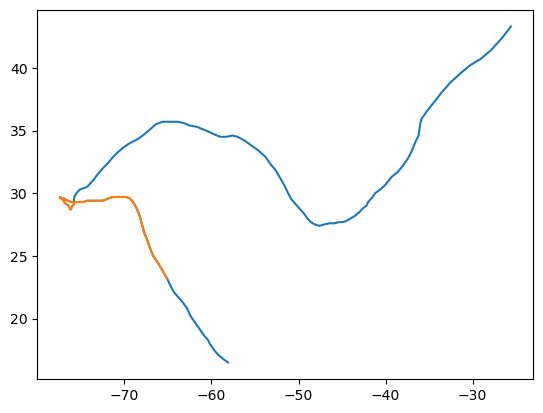

In [20]:
fig, ax = plt.subplots()
ax.plot(dummy0['lon'], dummy0['lat'])
ax.plot(dummy1['lon'], dummy1['lat'])

##### Setup simulations

Function to get the random tide was deleted by accident

In [14]:
def getRandomTide(dfs):
    ''' updated function 01/05/2023 only one storm as input
    '''
    # dfs = df[df['tc_number'] == tc]
    dur = (dfs['randomDate'].iloc[-1] - dfs['randomDate'].iloc[0]).total_seconds()/86400 + 3
    hh = dfs['randomDate'].iloc[0].hour
    dd = dfs['randomDate'].iloc[0].day
    mm = dfs['randomDate'].iloc[0].month
    yy = dfs['randomDate'].iloc[0].year
    with open(r'TideFac-Code-Executable/dates.txt', 'w') as fout:
        fout.write(f'{dur:0.3f}\n')
        fout.write(f'{hh:02d},{dd},{mm},{yy}')
    os.system(r'TideFac-Code-Executable/a.out < TideFac-Code-Executable/dates.txt > TideFac-Code-Executable/screen.txt')
    
    aux = pd.read_csv('tide_fac.out', skiprows=9, header = None, delim_whitespace = True,
                           names = [f'node_factor_{int(tc)}', f'eq_arg_{int(tc)}'])
    
    return aux

In [31]:
dftsDissShortDates = pd.read_pickle(pathin/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')
dftsDissShortDates.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,...,tc_number,headingDir,forwardSpeed,dist_to_NC0,dist_to_NC1,dist_to_NC2,dist_to_NC3,windIntersectNC,runIndex,randomDate
661882,1914.0,8.0,8.0,8.0,1.0,18.4,-57.2,977.0,33.3,42.184444,...,20688,308.659808,22.992033,2686.953059,2628.608326,2629.035686,2717.033833,0,0,2001-08-18 00:00:00
661883,1914.0,8.0,8.0,9.0,1.0,18.8,-57.7,974.8,34.7,41.670000,...,20688,321.340192,22.961274,2618.219660,2560.273293,2561.100602,2649.512945,0,0,2001-08-18 03:00:00
661884,1914.0,8.0,8.0,10.0,1.0,19.3,-58.1,972.7,36.2,41.155555,...,20688,315.000000,23.180369,2549.566884,2491.067745,2491.674043,2579.991109,0,0,2001-08-18 06:00:00
661885,1914.0,8.0,8.0,11.0,1.0,19.8,-58.6,970.1,37.9,40.641111,...,20688,308.659808,25.422414,2473.423921,2414.802012,2415.495806,2503.987030,0,0,2001-08-18 09:00:00
661886,1914.0,8.0,8.0,12.0,1.0,20.2,-59.1,968.3,39.2,40.126666,...,20688,326.309932,22.848793,2404.961590,2346.706346,2347.802917,2436.721142,0,0,2001-08-18 12:00:00


In [19]:
# tracks, tc_number, run_index, max_cat, st_lon, st_lat = [], [], [], [], [], []
# for tc in dftsDissShortDates['tc_number'].unique():
#     dftc = dftsDissShortDates[dftsDissShortDates['tc_number'] == tc]
#     ls = LineString(list(zip(dftc['lon'].values, dftc['lat'].values)))
#     tracks.append(ls)
#     tc_number.append(tc)
#     run_index.append(int(dftc['runIndex'].unique()))
#     max_cat.append(dftc['cat'].max())
#     st_lon.append(dftc['lon'].iloc[0])
#     st_lat.append(dftc['lat'].iloc[0])

# gdfTracks = gpd.GeoDataFrame({'geometry': tracks, 'tc_number': tc_number, 'run_index': run_index,
#                               'max_cat': max_cat, 'lon_gen': st_lon, 'lat_gen': st_lat})
# gdfTracks.to_file(r'../gis/gpkg/tracks_STORM_batch02_In.gpkg', driver = 'GPKG')

In [14]:
# print(f'min date: {dftsDissShortDates["randomDate"].min()}')
# print(f'max date: {dftsDissShortDates["randomDate"].max()}')

min date: 2001-07-01 03:00:00
max date: 2001-08-30 00:00:00


In [28]:
## First set up simulations ran on anvil used the full track by mistake. Those fort.22 files are renamed to fort.22_fullTrack
# pin = Path(r'../models/adcirc/concorde/batch02/01')
# listDirs = sorted([x for x in os.listdir(pin) if x.isdigit()])
# for r in listDirs:
#     os.rename(pin/r/'fort.22', pin/r/'fort.22_fullTrack')
#     break

In [34]:
# pathout = Path(r'../models/adcirc/concorde/batch02/02') ## hazel simulations
# pathout = Path(r'../models/adcirc/concorde/batch02/02b/temp') ## stampede2 simulations
pathout = Path(r'../models/adcirc/concorde/batch02/02/temp') ## stampede2 simulations

pathtemplate = pathout/'_template'

In [6]:
## used in batch02/02 to rerun simulations that failed in The Bahams
#dfBlowUp01 = pd.read_csv(r'../models/adcirc/concorde/batch02/01/_postprocessing/coordsBlowUps_0to430.csv', index_col = 0)
#dfBlowUp01Fl = dfBlowUp01[dfBlowUp01['y'] < 30]
#dftsDissShortDates = dftsDissShortDates.loc[dftsDissShortDates['runIndex'].isin(dfBlowUp01Fl.index), :]

In [9]:
# auxauxaux0 = pd.read_csv(r'/home/tomas/Insync/tacuevas@ncsu.edu/Google Drive/NCSU/thesis/models/adcirc/concorde/batch02/02b/runs_010923.csv')
# auxauxaux1 = [x for x in dftsDissShortDates.index if dftsDissShortDates.loc[x, 'runIndex'] in auxauxaux0['run'].to_list()]

# dftsDissShortDates = dftsDissShortDates.loc[auxauxaux1, :]
# dftsDissShortDates

In [32]:
# runs = pd.read_csv(r'../models/adcirc/concorde/batch02/runs_batch03.csv', index_col = 0)
runs = ['0006', '0008', '0135', '0179', '0215', '0300', '0394', '0414', '0421', '0427', '0429', '0431']
runs = pd.Series([int(x) for x in runs])
dftsDissShortDates = dftsDissShortDates[dftsDissShortDates['runIndex'].isin(runs)]#[40:])]
dftsDissShortDates.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,...,tc_number,headingDir,forwardSpeed,dist_to_NC0,dist_to_NC1,dist_to_NC2,dist_to_NC3,windIntersectNC,runIndex,randomDate
1417383,4050.0,8.0,2.0,183.0,1.0,19.3,-62.7,929.7,60.3,82.278346,...,44315,26.565051,16.341504,2216.851551,2183.117528,2200.349695,2301.561886,0,6,2001-07-09 21:00:00
1417384,4050.0,8.0,2.0,184.0,1.0,19.7,-62.5,930.6,60.0,82.832767,...,44315,18.434949,16.334785,2196.887389,2159.869160,2175.124177,2275.011923,0,6,2001-07-10 00:00:00
1417385,4050.0,8.0,2.0,185.0,1.0,20.0,-62.4,930.9,59.9,83.387187,...,44315,33.690068,11.607799,2178.941075,2139.735033,2153.676932,2252.674132,0,6,2001-07-10 03:00:00
1417386,4050.0,8.0,2.0,186.0,1.0,20.3,-62.2,930.7,60.1,83.941607,...,44315,26.565051,13.081937,2168.433568,2126.412617,2138.617213,2236.397217,0,6,2001-07-10 06:00:00
1417387,4050.0,8.0,2.0,187.0,1.0,20.7,-62.0,930.1,60.6,84.496028,...,44315,26.565051,16.317465,2150.485820,2105.083187,2115.198561,2211.490004,0,6,2001-07-10 09:00:00


In [33]:
len(dftsDissShortDates['runIndex'].unique())

12

In [6]:
# dftsDissShortDates = dftsDissShortDates[(dftsDissShortDates['runIndex'] > 500) & (dftsDissShortDates['runIndex'] <= 1200)] ## stampede2
# dftsDissShortDates = dftsDissShortDates[(dftsDissShortDates['runIndex'] >= 1760) & (dftsDissShortDates['runIndex'] <= 1900)] ## hazel

In [35]:
for itc, tc in tqdm(zip(dftsDissShortDates['runIndex'].unique(), dftsDissShortDates['tc_number'].unique())):

    dfs1 = dftsDissShortDates[dftsDissShortDates['tc_number'] == tc] ## shortened track
    dfr = pd.DataFrame(np.broadcast_to(dfs1.iloc[0, :].values, (8*3 + 1, len(dfs1.columns))),
                    columns = dfs1.columns)
    ## ramp period date, starts from first timesteps going backwards 3 days
    rampDates = [dfs1['randomDate'].iloc[0] - i*pd.Timedelta(hours = 3) for i in range(1, len(dfr)+1)][::-1]
    dfr['randomDate'] = rampDates
    dfr['min_press'] = [1013] * len(dfr) ## atmospheric pressure
    dfr['max_ws'] = [1] * len(dfr) ## 1knot wind speed

    date_aux0 = dfr['randomDate'].iloc[0]
    if date_aux0.hour == 0:
        dfr2 = dfr.copy()
    else:
        ## df ramp is extended until the starting hour is 00
        date_aux1 = datetime.datetime(date_aux0.year, date_aux0.month, date_aux0.day, 0)
        r_extra = pd.date_range(start = str(date_aux1), end = str(date_aux0), freq = '3H')
        dfr_extra = dfr.iloc[0:len(r_extra)-1, :]
        dfr_extra['randomDate'] = r_extra[:-1]
        dfr2 = pd.concat([dfr_extra, dfr])
        dfr2.index = range(len(dfr2))

    dfe = pd.concat([dfr2, dfs1], ignore_index = True)
    dftides = getRandomTide(dfe)

    namerun = f'{itc:04d}'

    try:
        os.mkdir(pathout/namerun)
    except:
        pass

    with open(pathout/namerun/f'tc_number.{tc}', 'w') as rdm:
        rdm.write(str(tc))

        ## write fort22
    with open(pathout/namerun/'fort.22', 'w') as fout:
        for i in dfe.index:
            d = dfe.loc[i, 'randomDate'].strftime('%Y%m%d%H')
            inc = int((dfe.loc[i, 'randomDate'] - dfe['randomDate'].iloc[0]).total_seconds()/(3600))
            lat = int(np.round(dfe.loc[i, 'lat'], 1)*10)
            lon = int(np.abs(np.round(dfe.loc[i, 'lon'], 1))*10)
            ws = int(np.round(dfe.loc[i, 'max_ws']*1.94384, 0)) ## meter per second to knots
            p = int(np.round(dfe.loc[i, 'min_press'], 0))
            rmw = int(np.round(dfe.loc[i, 'rad_to_max_ws'], 0))
            text = (
                    f'AL, 00, {d},   , BEST, {inc:3},{lat:4}N, {lon:4}W, '
                    f'{ws:3}, {p:4},   ,  00, XXX,  000,  000,   00,  000, 0000,     ,'
                    f' {rmw:3},     ,    ,    ,    ,    ,000,  00,  {tc:08d}  ,  00,    0, 0, 0, 0, 0,     00.0,'
                    f'   00.0,   00.0,   00.0,    0.0000,   0.0000,   0.0000,   0.0000,   0.0000,'
                    f' 000.0000, 000.0000, 000.0000, 000.0000\n')
            fout.write(text)

    pathout_sub = pathout/namerun
    
    ## modify fort.15
    filein = pathtemplate/'fort.15'
    fileout = pathout_sub/'fort.15'
    olds = ['XX1', 'XX2', 'YYYY_MM_DD_HHmm', 'DDD', 'RRR',
            'M2NODF1', 'M2EQA1', 'S2NODF1', 'S2EQA1', 'N2NODF1', 'N2EQA1', 'K2NODF1', 'K2EQA1', 'K1NODF1', 'K1EQA1', 
            'O1NODF1', 'O1EQA1', 'P1NODF1', 'P1EQA1', 'Q1NODF1', 'Q1EQA1',
            'M2NODF2', 'M2EQA2', 'S2NODF2', 'S2EQA2', 'N2NODF2', 'N2EQA2', 'K2NODF2', 'K2EQA2', 'K1NODF2', 'K1EQA2', 
            'O1NODF2', 'O1EQA2', 'P1NODF2', 'P1EQA2', 'Q1NODF2', 'Q1EQA2',
            'datedate']

    dftides_sub = dftides.loc[['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1'], [x for x in dftides.columns if x.endswith(f'_{tc}')]]
    constituents = [f'{x:.5f}' for x in dftides_sub.values.reshape(-1)]
    dur = (dfe['randomDate'].iloc[-1] - dfe['randomDate'].iloc[0]).total_seconds()/86400

    dramp = (dfr2['randomDate'].iloc[-1] - dfr2['randomDate'].iloc[0]).total_seconds()/86400
    news = [f'{itc:04d}', f'STORM{tc}', dfe['randomDate'].iloc[0].strftime('%Y %m %d %H00'), str(dur), str(dramp)]
    news.extend(constituents)
    news.extend(constituents)
    news.extend([str(dfe['randomDate'].iloc[0])])
    ascii_replace(filein, fileout, olds, news)
    
    ## modify adcprep and padcirc scripts
    # if hpc == 'hazel':
    olds0_hazel = ['ADCPREPADCPREP', 'XXX']
    news0_hazel = [f'{namerun}prep', '128']
    ascii_replace(pathtemplate/'adcprep.csh', pathout_sub/'adcprep.csh', olds0_hazel, news0_hazel)

    olds1_hazel = ['RUNRUN', 'NODESNODES']
    news1_hazel = [namerun, '128']
    ascii_replace(pathtemplate/'padcirc.csh', pathout_sub/'padcirc.csh', olds1_hazel, news1_hazel)

    # # elif hpc == 'anvil':
    # olds0_anvil = ['ADCPREPADCPREP', 'XXX']
    # news0_anvil = [f'{namerun}prep', '192']
    # ascii_replace(pathtemplate/'adcprep.sh', pathout_sub/'adcprep.sh', olds0_anvil, news0_anvil)

    # olds1_anvil = ['NODESNODES', 'TASKSTASKS', 'RUNRUN']
    # news1_anvil = ['192', '4', namerun]
    # ascii_replace(pathtemplate/'padcirc.sh', pathout_sub/'padcirc.sh', olds1_anvil, news1_anvil)

12it [00:00, 21.67it/s]


In [ ]:
## copy fort.13 fort.14 and executables
pathout = Path(r'/scratch/09536/tacuevas/02')
runs = [x for x in os.listdir(pathout) if x.isdigit()]

pathtemplate = pathout/'_template'
for r in runs:
    
    namerun = f'{r:04d}'
    pathout_sub = pathout/namerun
    filesIn = ['fort.13', 'fort.14', 'adcprep', 'padcirc']
    filesOut = ['fort.13', 'fort.14', 'adcprep', 'padcirc']

    for fi, fo in zip(filesIn, filesOut):
        shutil.copy(pathtemplate/fi, pathout_sub/fo)